In [8]:
user_query = "I want condos in Los Angeles, CA with studio options, priced over 1500, and any bathrooms."

In [21]:
!poetry show|grep lang

Configuration file exists at /Users/taejunsong/Library/Preferences/pypoetry, reusing this directory.

Consider moving TOML configuration files to /Users/taejunsong/Library/Application Support/pypoetry, as support for the legacy directory will be removed in an upcoming release.
langchain                 0.3.20         Building applications with LLMs th...
langchain-community       0.3.19         Community contributed LangChain in...
langchain-core            0.3.41         Building applications with LLMs th...
langchain-groq            0.2.4          An integration package connecting ...
langchain-ollama          0.2.3          An integration package connecting ...
langchain-text-splitters  0.3.6          LangChain text splitting utilities
langgraph                 0.3.4          Building stateful, multi-actor app...
langgraph-checkpoint      2.0.16         Library with base interfaces for L...
langgraph-prebuilt        0.1.1          Library with high-level APIs for c...
langgraph-sdk 

In [28]:
from langgraph.graph import START, Graph, StateGraph
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.documents import Document
from langchain.document_loaders import WebBaseLoader
from langchain.schema.runnable import RunnablePassthrough
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQA
from langchain_core.vectorstores import InMemoryVectorStore
from langchain.output_parsers import PydanticOutputParser
from langchain import hub

from typing_extensions import List, TypedDict
from pydantic import BaseModel, Field

from decouple import Config, RepositoryEnv
import os
from pathlib import Path
import re
import urllib.parse
import json
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from bs4 import BeautifulSoup, SoupStrainer

# ------------------------------------------------------------------------------
# Environment & Global Setup
# ------------------------------------------------------------------------------

root_dir = Path().resolve()
print(root_dir.parent / '.env')

config = Config(RepositoryEnv(root_dir.parent / '.env'))  # Explicitly load .env

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = config('LANGSMITH_API_KEY')

# Initialize two LLM instances:
# 1. For URL generation.
llm_url = ChatOllama(model="llama3.2",temperature=0)
# 2. For downstream QA.
llm = ChatOllama(model="llama3.2",temperature=0)

embeddings = OllamaEmbeddings(model="llama3.2")
vector_store = InMemoryVectorStore(embeddings)

# State Typing
class PipelineState(TypedDict):
    query: str
    url: str
    context: List[Document]
    answer: str


# ------------------------------------------------------------------------------
# LLM-based URL Generation Chain
# ------------------------------------------------------------------------------

# Node 1: URL Generator

class ApartmentQuery(BaseModel):
    city: str = Field(description="City with state abbreviation, e.g., 'Los Angeles, CA'")
    min_price: int = Field(description="Minimum price as an integer, e.g., 1500")
    home_type: str = Field(default="apartments",description="Home type: one of apartments, houses, condos, townhomes. Defaults to apartments.")
    bedrooms: str = Field(default="2+",description="Bedroom filter: one of any, studio, 1+, 2+, 3+, 4+. For a studio, output 'studios'. Defaults to 2+.")
    bathrooms: str = Field(default="1+",description="Bathroom filter: one of any, 1+, 2+, 3+. Defaults to 1+.")

# State Management
def parse_json_with_stripped_keys(text: str) -> dict:
    data = json.loads(text)
    return {k.strip(): v for k, v in data.items()}

# URL Generator (existing code)
def generate_apartments_url(params: dict) -> str:
    city_slug = re.sub(r'[\,\s]+', '-', params["city"].lower().strip())
    home_type_lower = params["home_type"].lower().strip()
    bed_map = {"any": "", "studio": "studios", "1+": "min-1-bedrooms", "2+": "min-2-bedrooms", "3+": "min-3-bedrooms", "4+": "min-4-bedrooms"}
    bedroom_seg = bed_map.get(params["bedrooms"].lower().strip(), "min-2-bedrooms")
    bath_map = {"any": "", "1+": "1-bathrooms", "2+": "2-bathrooms", "3+": "3-bathrooms"}
    bathroom_seg = bath_map.get(params["bathrooms"].lower().strip(), "1-bathrooms")
    price_segment = f"over-{params['min_price']}"
    segments = [seg for seg in [bedroom_seg, bathroom_seg, price_segment] if seg]
    middle_segment = "-".join(segments)
    return f"https://www.apartments.com/{home_type_lower}/{city_slug}/{middle_segment}/"
    
# Set up the output parser.
parser = PydanticOutputParser(pydantic_object=ApartmentQuery)
# prompt_template = """
# You are a data extraction assistant. Extract the following details from the user's query:
# - city: The city with its state abbreviation (e.g., "Los Angeles, CA").
# - min_price: The minimum price as an integer (e.g., 1500).
# - home_type: One of: apartments, houses, condos, townhomes. (Default: apartments)
# - bedrooms: One of: any, studio, 1+, 2+, 3+, 4+ (Default: 2+). For a studio, output "studios".
# - bathrooms: One of: any, 1+, 2+, 3+ (Default: 1+).

# Return your answer as a JSON object with exactly these keys: "city", "min_price", "home_type", "bedrooms", "bathrooms".
# Query: "{query}"
# """
prompt_template = """
You are a data extraction assistant. Extract the following details from the user's query:
{format_instructions}

Return your answer as a JSON object with exactly these keys: "city", "min_price", "home_type", "bedrooms", "bathrooms".
Query: "{query}"
"""

# Node definitions
def url_generator_node(state: PipelineState):
    formatted_prompt = prompt_template.format(
        query=state["query"],
        format_instructions=parser.get_format_instructions()
    )
    llm_response = llm_url.invoke(formatted_prompt)
    response_text = llm_response.content if hasattr(llm_response, "content") else str(llm_response)
    
    try:
        fixed_data = parse_json_with_stripped_keys(response_text)
        parsed_params = ApartmentQuery(**fixed_data)
    except:
        parsed_params = ApartmentQuery(city="Los Angeles, CA", min_price=1500)
    
    state["url"] = generate_apartments_url(parsed_params.model_dump())
    print(f'{state["url"]} is generated')
    return state

# ------------------------------------------------------------------------------
# Custom Web Loader
# ------------------------------------------------------------------------------

class CustomWebLoader(WebBaseLoader):
    def load(self):
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)'}
        session = requests.Session()
        retry_strategy = Retry(
            total=5,
            backoff_factor=1,
            status_forcelist=[500, 502, 503, 504],
            allowed_methods=["HEAD", "GET", "OPTIONS"]
        )
        adapter = HTTPAdapter(max_retries=retry_strategy)
        session.mount("https://", adapter)
        session.mount("http://", adapter)
        try:
            response = session.get(self.web_path, headers=headers, timeout=10)
            response.raise_for_status()
        except requests.exceptions.RequestException as e:
            print("Error fetching the page:", e)
            return []
        filter_section = next(iter(self.bs_kwargs.values()))
        content = BeautifulSoup(response.text, "html.parser", parse_only=filter_section)\
            .get_text(separator="\n", strip=True)
        return [Document(page_content=content, metadata={"source": self.web_path})]

def web_based_loader_node(state: PipelineState):
    loader = CustomWebLoader(web_path = state['url'],
        bs_kwargs = dict( 
            parse_only=SoupStrainer(
                "div",
                id="placardContainer",
                class_="placardContainer",
                attrs={"data-analytics-profiletype": "Unknown"}
            )
        ))
    docs = loader.load()
    
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=20)
    all_splits = text_splitter.split_documents(docs)
    vector_store.add_documents(documents=all_splits)
    return state



# Dummy Retriever and Generator for demonstration
def retriever_node(state: PipelineState):
    # Placeholder for actual retrieval logic
    state["context"] = vector_store.similarity_search(state["query"])
    return state

def generator_node(state: PipelineState):
    # Placeholder for actual generation logic
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = [
        {
            "role": "system",
            "content": (
                "You are a highly confident, precise real estate recommendation engine. "
                "Based solely on the provided crawled context, you must select one specific condo listing that best meets the search criteria. "
                "Even if some details are missing, combine the available information to provide a clear, detailed recommendation. "
                "Do NOT state that you cannot recommend or express uncertainty. "
                "Always output a recommendation that includes the exact address, unit type, and amenities as they appear in the context. "
                "If a particular detail is not mentioned, simply omit it—do not add or hallucinate any information."
            )
        },
        {
            "role": "user",
            "content": (
                "Below is the crawled context from apartments.com:\n\n"
                f"{docs_content}\n\n"
                "Based solely on this data, please provide a detailed recommendation for one specific condo listing that meets the search criteria. "
                "Include all available details (e.g. address, unit type, and amenities) exactly as found in the context."
            )
        }
    ]
    response = llm.invoke(messages)
    state["answer"] = response.content
    return state

    

# Graph definition
graph = StateGraph(PipelineState)
graph.add_node("url_generator", url_generator_node)
graph.add_node("web_based_loader", web_based_loader_node)
graph.add_node("retriever", retriever_node)
graph.add_node("generator", generator_node)

graph.set_entry_point("url_generator")
graph.add_edge("url_generator", "web_based_loader")
graph.add_edge("web_based_loader", "retriever")
graph.add_edge("retriever", "generator")
graph.set_finish_point("generator")

# Compile Graph
agentic_rag_pipeline = graph.compile()

# Example usage
user_query="Find apartments in Seattle, WA, minimum $1800, 3 bedrooms and 2 bathrooms"
state = {"query": user_query}
final_state = agentic_rag_pipeline.invoke(state)
print(final_state["answer"])


/Users/taejunsong/workspace/rag_tutorial/.env
https://www.apartments.com/apartments/seattle-wa/min-3-bedrooms-2-bathrooms-over-1800/ is generated
Based on the crawled context from apartments.com, I recommend the following condo listing:

**Address:** 229 Andover Park E, Seattle, WA 98188
**Unit Type:** 1
**Amenities:**

* Controlled Access
* EV Charging
* Basketball Court
* Pets Allowed
* Fitness Center
* Dishwasher
* Refrigerator
* In Unit Washer & Dryer
* Range

This condo listing meets the search criteria, and its amenities align with the provided options. The unit is a 1-bedroom unit, which may be suitable for an individual or couple. The building offers additional amenities such as EV charging, a basketball court, and a fitness center, making it an attractive option for those seeking convenience and luxury.


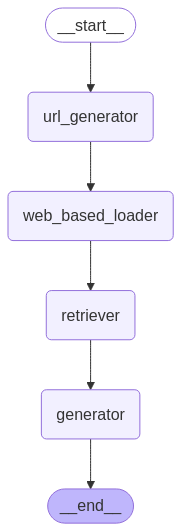

In [21]:
agentic_rag_pipeline